In [101]:
using Plots
using LinearAlgebra
using Random
using JLD
using StatsPlots
using ProgressMeter
include("/home/javier/Desktop/alpcahus/alpcahus.jl")
include("/home/javier/Desktop/alpcahus/cluster.jl")
include("/home/javier/Desktop/alpcahus/otherMethods.jl")
include("/home/javier/Desktop/alpcahus/adssc.jl")

lsr (generic function with 1 method)

In [102]:
Y1 = load("astroData_z2.jld","Yfull")
Y2 = load("astroData_z1.jld", "Yfull");
Y2 = Y2[:,randperm(MersenneTwister(12),size(Y2)[2])[1:2500]];
Y1 = Y1[51:281-50,randperm(MersenneTwister(12),size(Y1)[2])[1:2500]];
K = 2;

In [103]:
#Y1s = Y1[:, randperm(5000)[1:10]]
Y = hcat(Y1,Y2);
C = vcat(ones(2500), 2*ones(2500));

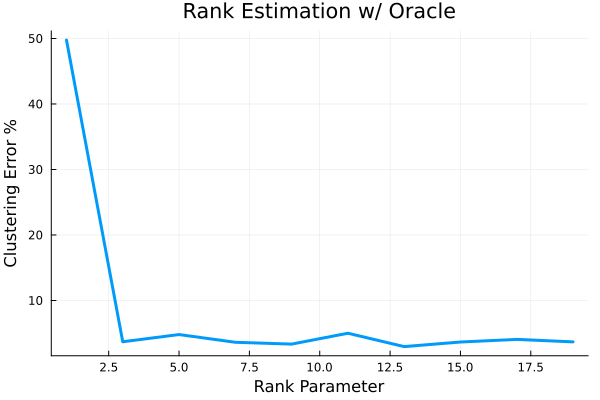

In [104]:
λ0 = 1:2:19
testVec = zeros(length(λ0))
for i=1:length(λ0)
U = []
for k=1:K
    push!(U,fastALPCAH(Y[:,C .== k], λ0[i]; varfloor=1e-9, alpcahIter= 100, fastCompute=false))
end
C_oracle = clusterAssignment(Y, U, K);
testVec[i] = clusterError(C,C_oracle)
end
plot(λ0, testVec, title="Rank Estimation w/ Oracle", xlabel="Rank Parameter", ylabel="Clustering Error %", linewidth=3, label="")

In [105]:
λ0 = 3; # rank parameter as seen in graph

# validation set up

In [107]:
Ytest = load("validationSet2.jld","Ytest")
Ctest = load("validationSet2.jld","Ctest")
Ytest2 = load("validationSet2_2.jld","Ytest")
Ctest2 = load("validationSet2_2.jld","Ctest");

# Validation based on random 200 sample, assuming rank 5 based on scree plot

# Ensemble KSS / ALPCAHUS

In [108]:
λ1 = [1 5 10 20 30 40 50 100] # q parameter 
testVec = zeros(4,length(λ1));

In [109]:
for i=1:length(λ1)
C_ekss = ALPCAHUS(Ytest,K,[λ0;λ0]; B=64, q=λ1[i], T=3, subspaceMethod=:pca, finalStep=false)
C_alpcahus = ALPCAHUS(Ytest,K,[λ0;λ0]; B=64, q=λ1[i], T=3, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true)
C_kss = ALPCAHUS(Ytest, K, [λ0;λ0]; B=1, q=λ1[i], T=100, subspaceMethod=:pca, finalStep=false, spectralStart=true)
C_alpcah = ALPCAHUS(Ytest,K, [λ0;λ0]; B=1, q=λ1[i], T=100, alpcahIter=10, subspaceMethod=:alpcah, finalStep=true, spectralStart=true)
testVec[1,i] = clusterError(Ctest,C_ekss)
testVec[2,i] = clusterError(Ctest,C_alpcahus)
testVec[3,i] = clusterError(Ctest, C_kss)
testVec[4,i] = clusterError(Ctest, C_alpcah)
end

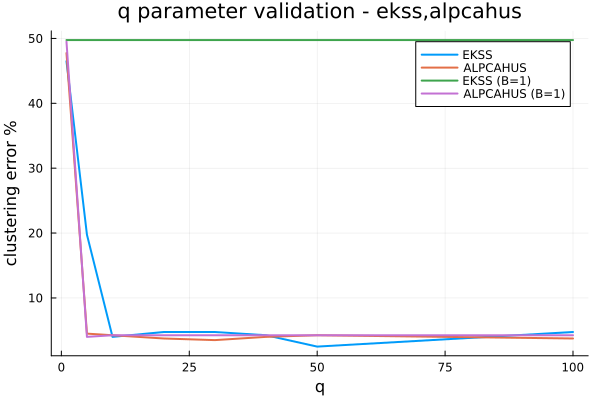

In [110]:
plot(title="q parameter validation - ekss,alpcahus", xlabel="q", ylabel="clustering error %")
plot!(λ1[:], testVec[1,:], label="EKSS", linewidth=2)
plot!(λ1[:], testVec[2,:], label="ALPCAHUS", linewidth=2)
plot!(λ1[:], testVec[3,:], label="EKSS (B=1)", linewidth=2)
plot!(λ1[:], testVec[4,:], label="ALPCAHUS (B=1)", linewidth=2)

In [111]:
λ1 = 20; # seems like q=20 gives  the best result for all of them , going larger leads to the same clustering error so pointless to increase

# ADSSC

In [112]:
λ2 = [0.01 0.1 1 10 100 1000]
λ3 = [0.01 0.1 1 10 100 1000]
testMatrix = zeros(length(λ2), length(λ3))
for i = 1:length(λ2)
    for j = 1:length(λ3)
        C_adssc = adsscWrapper(Ytest, λ2[i],λ3[j]; K=2)
        testMatrix[i,j] = clusterError(Ctest, C_adssc)
    end
end
λ2 = λ2[argmin(testMatrix)[1]];
λ3 = λ3[argmin(testMatrix)[2]];

In [113]:
testMatrix[argmin(testMatrix)] # clustering error

8.5

# TSC

In [114]:
λ4 = [1 5 7 10 12 15 20 25 50]
testVec = zeros(length(λ4));

In [115]:
for i = 1:length(λ4)
    C_tsc = tscWrapper(Ytest2, λ4[i]; K=2)
    testVec[i] = clusterError(Ctest2,C_tsc)
end

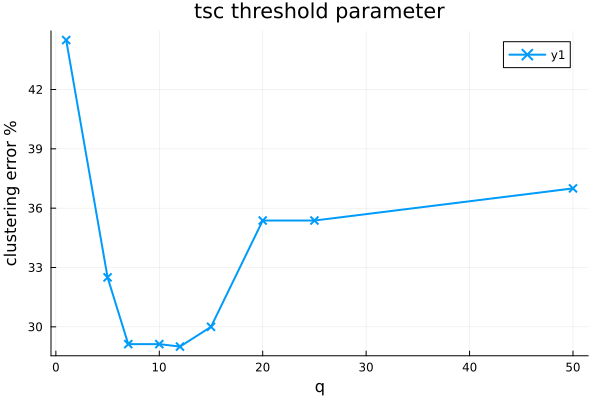

In [116]:
plot(λ4[:], testVec, title="tsc threshold parameter", xlabel="q", ylabel="clustering error %", marker=:x, linewidth=2)

In [117]:
λ4 = 10; 

# K means

In [118]:
# kmeans
C_kmeans = kmeans(Elkan(), Ytest, 2; k_init="k-means++").assignments
clusterError(Ctest,C_kmeans)

49.75

In [119]:
# k means does not work well with this dataset, worth dropping from results

# save parameters for testing

In [121]:
params = Dict("rank" => λ0, "ekss" => λ1, "alpcahus" => λ1, "adssc" => [λ2;λ3], "tsc" => λ4);
save("params2.jld","params",params);

# hemppcat

In [6]:
using Revise
include("../hemppcat_code/mppca/MPPCA.jl")
using .MPPCA
include("../hemppcat_code/hemppcat/HeMPPCAT.jl")
using .HeMPPCAT

In [10]:
function hemppcatWrapperTSC(X::Matrix; K::Int=2, λ0::Int=3, λ4::Int=10)
    D,N = size(X)
    c = tscWrapper(X, λ4; K=K)
    
    T1 = svd(X[:,c .== 1])
    T2 = svd(X[:,c .== 2])
    F1 = T1.U[:,1:λ0]*Diagonal(sqrt.(T1.S[1:λ0]))
    F2 = T2.U[:,1:λ0]*Diagonal(sqrt.(T2.S[1:λ0]))
    
    F_init = [F1 , F2] # Factor matrices
    μ_init = zeros(D, K) # Mixture means
    π_init = [0.5, 0.5] # Mixing proportions
    
    v_init = ones(N)
    n = ones(Int,N) # number of points in each variance group
    
    # Mixture HEPPCAT
    model = create_HeMPPCATModel(F_init, μ_init, π_init, v_init, n) # Initialize a HeMPPCATModel object
    Y = [c[:] for c in eachcol(X)]
    results, _ = hemppcat(model, Y; eps=1e-1); # Run HeMPPCAT
    
    U1 = svd(results.F[1]).U
    U2 = svd(results.F[2]).U
    labelsHEMPPCAT = clusterAssignment(X, [U1,U2], K)
    
    return labelsHEMPPCAT
end

C_hemppcat = hemppcatWrapperTSC(Ytest)
clusterError(Ctest,C_hemppcat)

LoadError: ArgumentError: matrix contains Infs or NaNs